In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls /content/drive//MyDrive/

 Audio		     CNN-CLASSIFICAZIONE	 DOCUMENTI_POP_OS  'RIVISTA HACKING'
 BIG_DATA_PROGETTO  'Colab Notebooks'		 GIAPPONE
 Capo		     ComputerVision		'Manutenzione '
 CAPODANNO2024	     dataset-civiltà-contadina	 NATALE2023


In [8]:
!ls /content/drive//MyDrive/CNN-CLASSIFICAZIONE

 0-SimplePredictionMNIST.ipynb	'1.0 - DogCat - Fine-tuning_noGenerator.ipynb'	 ToUpload
 0-SimplePredictionVGG16.ipynb	 dog_cat_dataset_ridotto


In [25]:
# Let's start by importing the required libraries
# Importing from keras or from tensorflow.keras is equivalent for tf.version > 2
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import Sequence as Sequence
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import random_rotation, random_shear, random_shift

In [2]:
def preprocess(path, img_rows, img_cols):
  imgs_array = []
  label_array = []

  for file_name in os.listdir(path):
    img = load_img(os.path.join(path, file_name),
                  target_size = (img_rows, img_cols))

    # If the image's name starts with "cat" then the label will be 0, otherwise 1
    if file_name.startswith('cat'):
      label_array.append(0)
      x = img_to_array(img)
      # Apply the same preprocessing that was used when VGG16 was trained
      x = preprocess_input(x)
      # Images are added to a list
      imgs_array.append(x)
    else:
      label_array.append(1)
      x = img_to_array(img)
      x = preprocess_input(x)
      imgs_array.append(x)

  # Data are converted to an array
  imgs_array = np.asarray(imgs_array)
  label_array = np.asarray(label_array)

  return imgs_array, label_array

In [10]:
# Path to my dataset: EDIT IT WITH YOUR OWN PATH to the folder dog_and_cat
path = "/content/drive/MyDrive/CNN-CLASSIFICAZIONE/dog_cat_dataset_ridotto"

# Image size
immg_rows = 224
immg_cols = 224

# Preprocessing and shuffle
# Random state allows to obtain the same shuffle over time

new_array, new_label = preprocess(path, immg_rows, immg_cols)
new_array, new_label = shuffle(new_array, new_label, random_state=24)

images shape: (16, 224, 224, 3)
labels shape: (16,)


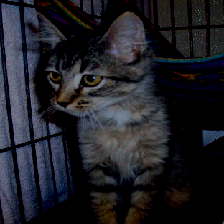

WHICH LABEL?  0


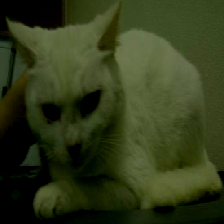

WHICH LABEL?  0


In [11]:
# Let's see if we are doing well
from google.colab.patches import cv2_imshow
print("images shape:", new_array.shape)
print("labels shape:", new_label.shape)
cv2_imshow(new_array[3,:,:,:])
print("WHICH LABEL? ", new_label[3])
cv2_imshow(new_array[2,:,:,:])
print("WHICH LABEL? ", new_label[2])

In [14]:
from sklearn.model_selection import train_test_split

# Split in dataset in train-test
Xtrain, X_test, ytrain, y_test = train_test_split(new_array,new_label, test_size=0.30, stratify=new_label, random_state=42)

# Split train in train-valid
X_train, X_valid, y_train, y_valid = train_test_split(Xtrain, ytrain, test_size=0.20, stratify=ytrain, random_state=42)

In [15]:
#This is just an example of data augmentation: there are so many functions that you can use!

from keras.preprocessing.image import random_shift as rand_shift
from keras.preprocessing.image import random_rotation as rand_rotation


def flip_axis(x, axis=1):
  cp = np.copy(x)
  cp = np.asarray(cp).swapaxes(axis, 0)
  cp = cp[::-1, ...]
  cp = cp.swapaxes(0, axis)
  return cp


def augment_data(images, labels, augementation_factor=1, do_flip_axis=False,
                 do_rand_rotation=False, do_rand_shift=False):

  augmented_image = []
  augmented_labels = []
  for id, img in enumerate(images):
    # original image:
    augmented_image.append(img)
    augmented_labels.append(labels[id])

    for i in range(augementation_factor):
      # flipping
      if do_flip_axis:
        augmented_image.append(flip_axis(img))
        augmented_labels.append(labels[id])
      # Random rotation
      if do_rand_rotation:
        augmented_image.append(rand_rotation(img, 60, row_axis=0,
                        col_axis=1, channel_axis=2, fill_mode='constant'))
        augmented_labels.append(labels[id])
      # Random spatial shift
      if do_rand_shift:
        augmented_image.append(rand_shift(img, 0.2, 0.2, row_axis=0,
                          col_axis=1, channel_axis=2, fill_mode='constant'))
        augmented_labels.append(labels[id])

  augmented_image = shuffle(augmented_image, random_state=24)
  augmented_labels = shuffle(augmented_labels, random_state=24)
  return np.array(augmented_image), np.array(augmented_labels)

In [16]:
# Apply data augmentation
# In this case we only flipped the images. If we wanna apply the other functions, just change the False with True

X_train_augm, y_train_augm = augment_data(X_train, y_train, do_rand_rotation=True, do_flip_axis=True)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_train_augm.shape)
print(y_train_augm.shape)
print(f"we have {X_train_augm.shape[0]//X_train.shape[0]} times more images")

(8, 224, 224, 3)
(8,)
(24, 224, 224, 3)
(24,)
we have 3 times more images


In [19]:
# First, we will load a VGG model without the top layers (the fully connected ones)
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers, Sequential
from keras import optimizers

vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (immg_rows, immg_cols, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

58889256/58889256 [==============================] - 4s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x7b0e38a67910> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2afc66e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac18190> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b0e2ac18f10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac19780> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac19ed0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b0e2ac1b460> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac1bcd0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac1bf10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0e2ac1be50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7b0e2a2a1c90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b0

In [20]:
model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [23]:
# Create a directory where the model weights will be saved
path_ = path[:path.find("/content/drive/MyDrive/CNN-CLASSIFICAZIONE")]
print("This is a directory", path_)
os.mkdir(os.path.join(path_, "results_"))
res_dir = os.path.join(path_, "results_")

This is a directory 


In [33]:
!pip install keras

In [34]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 516.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=bc8347ab6171f8509127736d33cfe3663ef91428bda4dd5ccdda27d46435b214
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import numpy as np
from keras.utils import to_categorical
# versione vecchia: from keras.utils.np_utils import to_categorical

print(to_categorical(y_valid))
print(to_categorical(y_train_augm))

In [41]:
#from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

num_epochs = 20

# Converts a class vector (integers) to binary class matrix-->this because we have 2 neurons at the end
y_train_augm = to_categorical(y_train_augm, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)


checkpoint = ModelCheckpoint(os.path.join(res_dir, "model.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="categorical_crossentropy", metrics="Recall",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9))

history = model.fit(X_train_augm, y_train_augm, epochs=num_epochs, batch_size=32, validation_data=(X_valid, y_valid), verbose=1, callbacks=[checkpoint])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 14.9694 - recall: 0.4583
Epoch 1: val_loss improved from inf to 0.00000, saving model to results_/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 15s 15s/step - loss: 14.9694 - recall: 0.4583 - val_loss: 5.5631e-07 - val_recall: 1.0000
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.1620 - recall: 0.9167
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to results_/model.h5
1/1 [==============================] - 3s 3s/step - loss: 1.1620 - recall: 0.9167 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.3990 - recall: 0.9167
Epoch 3: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 231ms/step - loss: 0.3990 - recall: 0.9167 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.0000e+00 - recall: 1.0000
Epoch 4: val_loss did not improve from 0.00000
1/1 [==============================] - 0s 200ms/step - loss: 0.0000e+00 - recall: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000
Epoch 5/20
1/1 [=============

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["recall"], label="train_rec")
plt.plot(np.arange(0, epochs), history.history["val_rec"], label="val_rec")

In [42]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, 1)

print(sklearn.metrics.classification_report(y_test, y_pred_max))
print("accuracy:",accuracy_score(y_test, y_pred_max))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

accuracy: 1.0


In [43]:
test_loss, test_acc = model.evaluate(X_test, to_categorical(y_test, num_classes = 2))

1/1 [==============================] - 0s 96ms/step - loss: 0.0000e+00 - recall: 1.0000


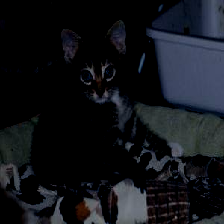

final activations: [1. 0.]. it's a cat


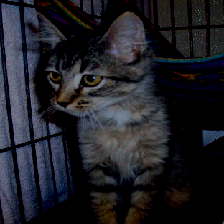

final activations: [1. 0.]. it's a cat


In [44]:
cv2_imshow(X_test[0,:,:,:])
print(f"final activations: {y_pred[0]}. it's a {'cat' if y_pred_max[0] == 0 else 'dog'}")
cv2_imshow(X_test[4,:,:,:])
print(f"final activations: {y_pred[4]}. it's a {'cat' if y_pred_max[4] == 0 else 'dog'}")